In [1]:
#Start Python Imports
import math, time, random, datetime

#Data manipulation
import numpy as np
import pandas as pd

#Visualisation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use("seaborn-whitegrid")

#Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

#Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

import warnings
warnings.filterwarnings("ignore")

In [8]:
# Import train and test data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
gender_submission = pd.read_csv("./data/gender_submission.csv")

In [9]:
# View the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
len(train)

891

In [11]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
len(test)

418

## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [13]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Visual indication of missing information

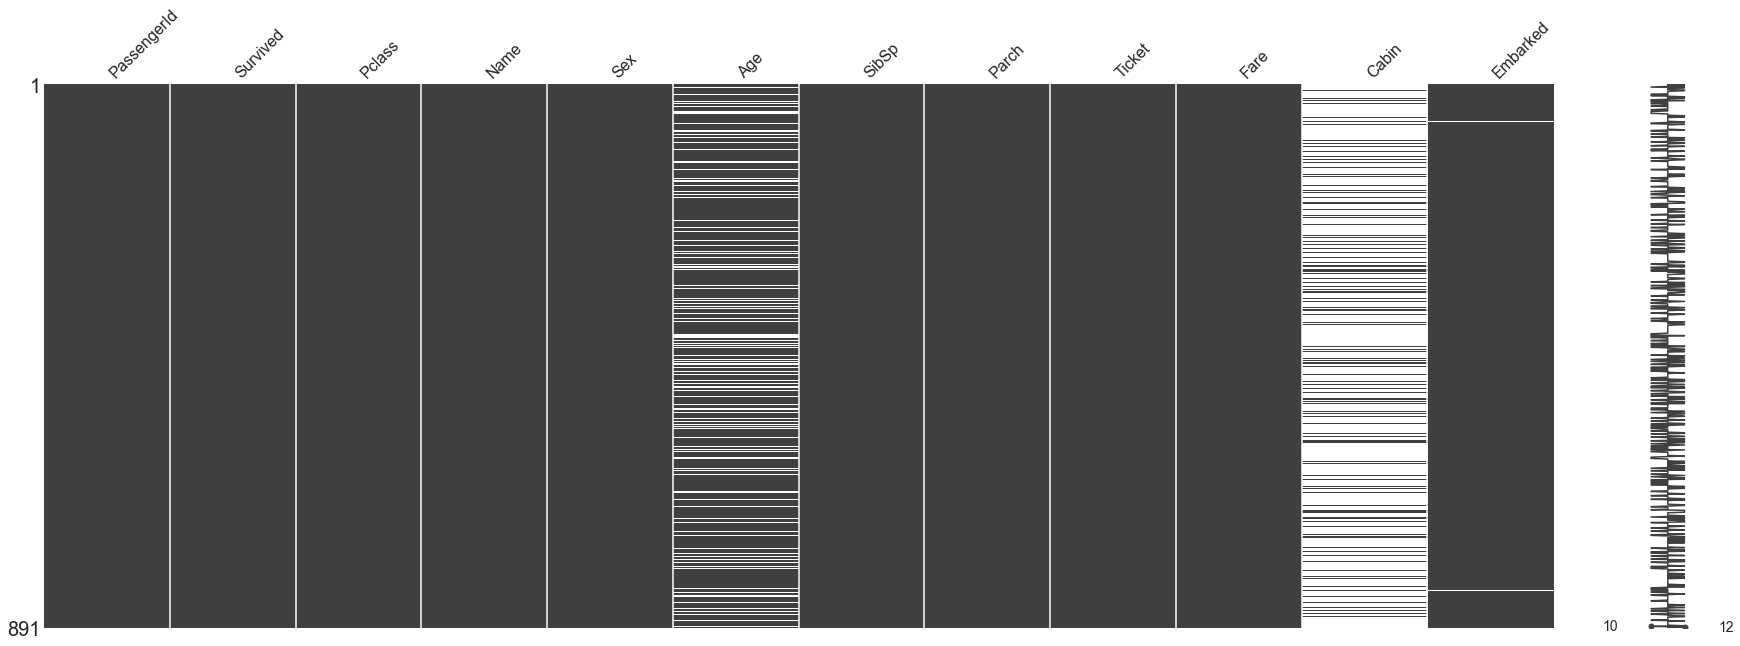

In [16]:
missingno.matrix(train, figsize=(30,10))

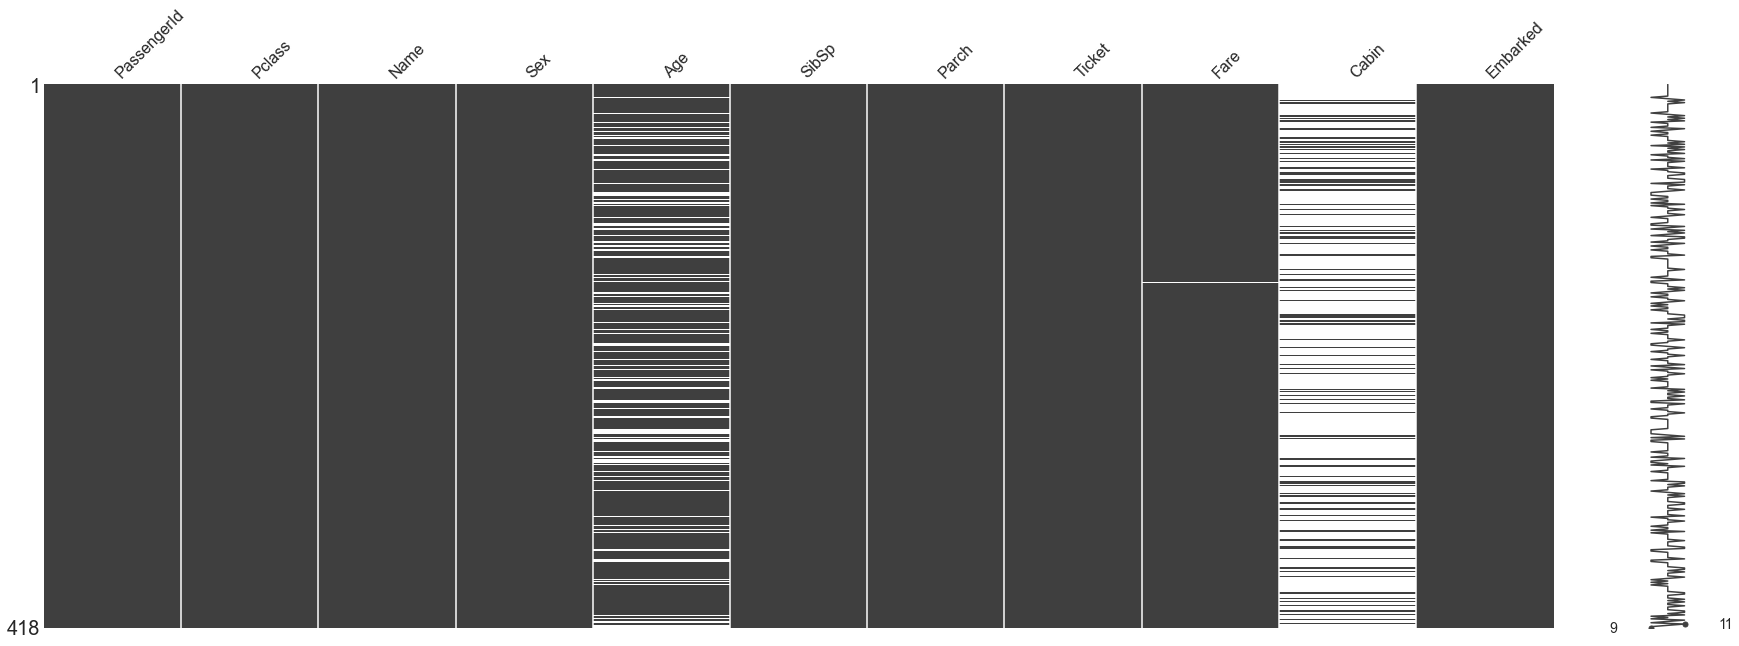

In [17]:
missingno.matrix(test, figsize=(30,10))

There are a bit of missing information, especially in the cabin column. Let's see just how many 

In [19]:
def find_missing_values(df, columns):
    """
    Finds teh number of rows where certain coilumns are missing values. 
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    
    missing_vals={}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
    return missing_vals

missing_values = find_missing_values(train, columns=train.columns)
missing_values
        

Number of missing or NaN values for each column:


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [26]:
train["Ticket"].value_counts()

347082         7
CA. 2343       7
1601           7
3101295        6
347088         6
              ..
347081         1
315082         1
347068         1
W./C. 14263    1
PC 17483       1
Name: Ticket, Length: 681, dtype: int64